In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from shutil import copy2
from keras.preprocessing import image
from keras import models, layers, optimizers, losses, metrics
from tensorflow.python.client import device_lib # uses GPU for keras

Using TensorFlow backend.


In [2]:
attribute_labels = "attribute_labels.json"  #~590Mb
mvc_info = "mvc_info.json"                  #~140Mb

img_mvc = "./images/mvc/"
img_selected = "./images/images_selected/"

In [3]:
df_labels = pd.read_json(attribute_labels)
df_mvc_info = pd.read_json(mvc_info)

## 1. Quick exploration of the colors

In [19]:
df_labels.head()

,AlineDresses,AnimalPrint,Anoraks,Argyle,Asymmetrical,Athletic,BabyDollDresses,BalconetteBras,Bandeau,BandeauBras,...,Zipper,fiftyU,filename,halfZip,hundred1U,hundred2O,hundred2U,itemN,quarter3Zip,quarterZip
0,0,0,0,0,0,0,0,0,0,0,...,0,0,p7258521_s3163710_v0,0,0,0,1,3163710.0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,p7258521_s3163710_v1,0,0,0,1,3163710.0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,p7258521_s3163710_v2,0,0,0,1,3163710.0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,p7258521_s3163710_v3,0,0,0,1,3163710.0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,p7258521_s3163710_v4,0,0,0,1,3163710.0,0,0


In [5]:
#dropping all views photos except "_v0"
df_labels_v0 = df_labels.drop_duplicates(subset="itemN", keep="first", inplace=False)
df_labels_v0.shape
#converting itemN column to integer (rounded first to avoid missconversion)
#df_colors.itemN = df_colors.itemN.round().astype(int)
#print(df_colors.shape)

(37499, 266)

In [6]:
colors = ['Beige', 'Black', 'Blue', 'Bronze', 'Brown', 'Burgundy',
          'Coral', 'Gold', 'Gray', 'Green', 'Olive', 'Orange', 'Pink', 'Purple',
          'Red', 'Silver', 'White', 'Yellow']

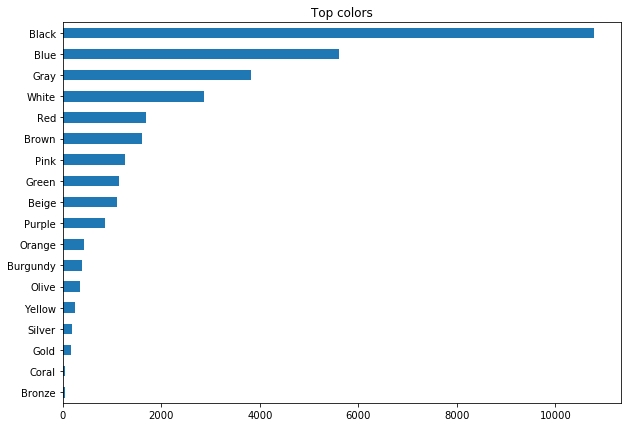

In [7]:
df_labels_v0[colors].sum(axis=0).sort_values().plot(kind="barh", figsize=(10,7), title="Top colors")
plt.show()

## 2. Transform dataframe from a "dummy" table to a labeled one

In [8]:
df_colors = df_labels_v0[colors]
df_colors.head()

,Beige,Black,Blue,Bronze,Brown,Burgundy,Coral,Gold,Gray,Green,Olive,Orange,Pink,Purple,Red,Silver,White,Yellow
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
20,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
color_labels = df_colors.dot(df_colors.columns)

In [10]:
df_color_labels = pd.DataFrame({'Color':color_labels.values}, index=color_labels.index).replace('', np.nan)
df_color_labels.head()

,Color
0,Gray
5,Brown
10,Blue
15,Gray
20,Black


In [11]:
df_color_labels = df_color_labels.merge(df_labels[['filename']], left_index=True, right_index=True)
df_color_labels.head()

,Color,filename
0,Gray,p7258521_s3163710_v0
5,Brown,p7258521_s3163713_v0
10,Blue,p7258521_s3119732_v0
15,Gray,p7258521_s2696572_v0
20,Black,p7258521_s3119730_v0


In [12]:
df_color_labels.shape

(37499, 2)

In [13]:
df_color_labels.dropna(axis=0, inplace=True)
df_color_labels.shape

(32556, 2)

Not all clothes have a color label. In fact 4943 do not have any

In [14]:
# removing duplicate images

def remove_dups(df):
    df_delete = pd.read_csv("duplicates_delete.csv", index_col=0)
    for filename in df_delete['filename']:
        dup_index = df[df["filename"].str.contains(filename)].index
        df.drop(dup_index, inplace=True)

remove_dups(df_color_labels)

In [15]:
df_color_labels.shape

(32537, 2)

## 3. First simple model for the top two categories: black, blue

In [35]:
def structure_images(df, classes, n_images, data_split, images_path):
    """
    - classes need to match the category labels
    - n_images is n images per class
    - data_split refers to the train, test, val ratio, need to be in format [train, test, val], ie. [0.8, 0.1, 0.1]
    - images_path is the absolute path to the img folder
    """
    assert (type(classes) == list)&(type(n_images) == list)&(type(data_split) == list), "needs to be in list format"
    
    folders = {0: "train", 1: "test",2: "valid"}
    path_cwd = os.getcwd() #using output path by default

    for n, each_class in enumerate(classes):
        clothes_class = df[df["Color"].str.contains(each_class)].sample(n=n_images[n], random_state=2018)["filename"].tolist()
        #make folders and subfolders
        for folder_n in range(len(folders)):
            os.makedirs(path_cwd + "/deeplearning_images_model/" + folders[folder_n] +"/"+ each_class.lower(), exist_ok=True)
        #split dataset into train / test / val
        clothes_train, clothes_test, clothes_val = np.split(
            clothes_class,
            [int(data_split[0]*len(clothes_class)),
             int((data_split[0] + data_split[1])*len(clothes_class))]
            )
        clothes_list = [clothes_train, clothes_test, clothes_val]
    
        for n, list_images in enumerate(clothes_list): #iterate over train test val
            for img_name in list_images: #iterate over each filename
                origin_path = os.path.join(images_path, img_name + ".jpg")
                destination_path = os.path.join(path_cwd, "deeplearning_images_model",
                                                folders[n],each_class.lower(), img_name + ".jpg")
                copy2(origin_path, destination_path) #will copy the images from origin to destination folder

In [36]:
%%time
structure_images(df_color_labels,
                 ["Black", "Blue"],
                 [5000,5000],
                 [0.8, 0.1, 0.1],
                 images_path=img_selected
                )

Wall time: 3min 2s


In [24]:
#links to where the imgs for the model are
train_path = "deeplearning_images_model/train"
test_path = "deeplearning_images_model/test"
valid_path = "deeplearning_images_model/valid"

train_batches = image.ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_path, target_size=(150,150), class_mode="binary", batch_size=200, seed=2018
)
test_batches = image.ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path, target_size=(150,150), class_mode="binary", batch_size=200, seed=2018, shuffle=False
)
valid_batches = image.ImageDataGenerator(rescale=1./255).flow_from_directory(
    valid_path, target_size=(150,150), class_mode="binary", batch_size=200, seed=2018
)

Found 8000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [25]:
train_batches.class_indices

{'black': 0, 'blue': 1}

In [54]:
# this functions plots images along with it´s label to have a better understading of the data
def plots(imgs, figsize=(20,6), rows=2, interp=False, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(imgs)//rows if len(imgs) % 2 == 0 else len(imgs) // rows + 1
    for i in range(len(imgs)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(imgs[i], interpolation=None if interp else'none')

In [ ]:
train_images, train_labels = train_batches[0]
valid_images, valid_labels = valid_batches[0]

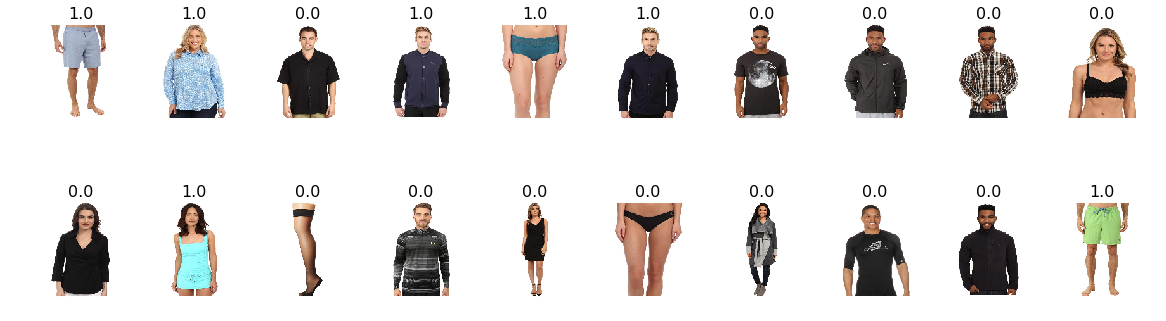

In [45]:
plots(train_images[50:70], titles=train_labels[50:70])
plt.show()

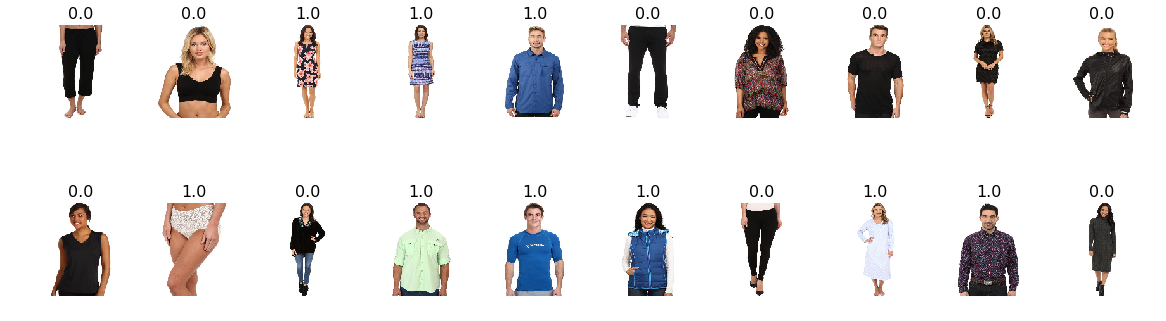

In [47]:
plots(valid_images[50:70], titles=valid_labels[50:70])
plt.show()

In [26]:
%%time
m  = models.Sequential()
m.add(layers.Convolution2D(32, (3,3), activation="relu", input_shape=(150,150,3)))
m.add(layers.MaxPooling2D((2,2)))
m.add(layers.Convolution2D(64, (3,3), activation="relu"))
m.add(layers.MaxPooling2D((2,2)))
m.add(layers.Convolution2D(128, (3,3), activation="relu"))
m.add(layers.MaxPooling2D((2,2)))
m.add(layers.Flatten())
m.add(layers.Dense(128, activation="relu"))
m.add(layers.Dense(64, activation="relu"))
m.add(layers.Dense(1, activation="sigmoid"))

m.compile(
    optimizer=optimizers.rmsprop(),
    loss=losses.binary_crossentropy,
    metrics=[metrics.binary_accuracy]
)

# need to understand how steps_per_epoch and validation_steps affects to our model when using batches
# ideally the steps should be: total images / batch size
# steps_per_epoch: 8000/200 = 40
# validation_steps: 1000/200 = 5
# However, after applying the same logic for validation_steps the model accuracy drops to 0.50 so we also use 40

h = m.fit_generator(train_batches, epochs=7, steps_per_epoch=20, 
                    validation_data=valid_batches, validation_steps=20)

Epoch 1/7
20/20 [==============================] - 29s 1s/step - loss: 1.0417 - binary_accuracy: 0.5828 - val_loss: 0.5237 - val_binary_accuracy: 0.7980
Epoch 2/7
20/20 [==============================] - 21s 1s/step - loss: 0.5371 - binary_accuracy: 0.7667 - val_loss: 0.3612 - val_binary_accuracy: 0.8450
Epoch 3/7
20/20 [==============================] - 21s 1s/step - loss: 0.3785 - binary_accuracy: 0.8390 - val_loss: 0.4614 - val_binary_accuracy: 0.8400
Epoch 4/7
20/20 [==============================] - 21s 1s/step - loss: 0.3153 - binary_accuracy: 0.8760 - val_loss: 0.2765 - val_binary_accuracy: 0.8870
Epoch 5/7
20/20 [==============================] - 21s 1s/step - loss: 0.3167 - binary_accuracy: 0.8730 - val_loss: 0.2387 - val_binary_accuracy: 0.8980
Epoch 6/7
20/20 [==============================] - 21s 1s/step - loss: 0.2596 - binary_accuracy: 0.8982 - val_loss: 0.2752 - val_binary_accuracy: 0.8800
Epoch 7/7
20/20 [==============================] - 21s 1s/step - loss: 0.2547 - bi

In [27]:
loss, acc = m.evaluate_generator(test_batches)
print(loss, acc)
print((1-acc)*test_batches.samples, "wrongly classified")

0.258985427022 0.898999989033
101.000010967 wrongly classified


In [ ]:
%%time
def wrongly_classified(model):
   
    a = 0
    b = 0
    
    predictions_test_all = model.predict_generator(test_batches).round(2).reshape(1,-1)[0]
    
    for i in range(len(test_batches)):
        a = test_batches.batch_size*i
        b = test_batches.batch_size*i + len(test_batches[i][0])
        
        predictions_test = predictions_test_all[a:b]
        test_preds = predictions_test.round()
        test_labels = test_batches[i][1]
    
        print('Batch ' + str(i+1) + ':', np.absolute(test_preds - test_labels).sum(), "wrongy classified") #needs to reconcile with the number of wrong predictions
        wrong_preds = np.where(test_preds - test_labels)[0] #indexes of wrong predictions
    
        for n in wrong_preds:
            print(predictions_test[n], test_batches.class_indices)
            plt.imshow(test_batches[i][0][n])
            plt.axis('Off')
            plt.show()
        
        print('-'*100)

wrongly_classified(m) # we need to add test_batches.filenames to get a dataframe with all incorrect images

### It seems that some images have been incorrectly labeled 


In [180]:
wrongly_labeled(df_labels[['Black', 'Blue', 'filename']], wrong_label)

,Black,Blue,filename
14199,1,0,p8157131_s3129330_v0
14159,1,0,p8157133_s3163623_v0
16844,1,0,p8218909_s2434418_v0
28481,1,0,p8333017_s3161742_v0
29981,1,0,p8347527_s3224951_v0
55298,1,0,p8523855_s3146691_v0
90869,1,0,p8579114_s3279476_v0
139218,1,0,p8645469_s3430601_v0
144049,1,0,p8649957_s3441042_v0


## 4. Create a model for 4 categories: black, blue, gray, white

In [78]:
def structure_images(df, classes, n_images, data_split, images_path):
    """
    - classes need to match the category labels
    - n_images is n images per class
    - data_split refers to the train, test, val ratio, need to be in format [train, test, val], ie. [0.8, 0.1, 0.1]
    - images_path is the absolute path to the img folder
    """
    assert (type(classes) == list)&(type(n_images) == list)&(type(data_split) == list), "needs to be in list format"
    
    folders = {0: "train", 1: "test",2: "valid"}
    path_cwd = os.getcwd() #using output path by default

    for n, each_class in enumerate(classes):
        clothes_class = df[df["Color"].str.contains(each_class)].sample(n=n_images[n], random_state=2018)["filename"].tolist()
        #make folders and subfolders
        for folder_n in range(len(folders)):
            os.makedirs(path_cwd + "/deeplearning_images_model/" + folders[folder_n] +"/"+ each_class.lower(), exist_ok=True)
        #split dataset into train / test / val
        clothes_train, clothes_test, clothes_val = np.split(
            clothes_class,
            [int(data_split[0]*len(clothes_class)),
             int((data_split[0] + data_split[1])*len(clothes_class))]
            )
        clothes_list = [clothes_train, clothes_test, clothes_val]
    
        for n, list_images in enumerate(clothes_list): #iterate over train test val
            for img_name in list_images: #iterate over each filename
                origin_path = os.path.join(images_path, img_name + ".jpg")
                destination_path = os.path.join(path_cwd, "deeplearning_images_model",
                                                folders[n],each_class.lower(), img_name + ".jpg")
                copy2(origin_path, destination_path) #will copy the images from origin to destination folder

In [79]:
%%time
structure_images(df_color_labels,
                 ["Black", "Blue", "Gray", "White"],
                 [10000,5000,3000,2000],
                 [0.8, 0.1, 0.1],
                 images_path=img_selected
                )

Wall time: 2min 54s


In [80]:
#links to where the imgs for the model are
train_path = "deeplearning_images_model/train"
test_path = "deeplearning_images_model/test"
valid_path = "deeplearning_images_model/valid"

train_batches = image.ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_path, target_size=(150,150), class_mode="categorical", batch_size=200, seed=2018
)
test_batches = image.ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path, target_size=(150,150), class_mode="categorical", batch_size=200, seed=2018, shuffle=False
) # if shuffle=True the images indices are shuffled then it will be harder to reconcile the labels # test_batches.index_array
valid_batches = image.ImageDataGenerator(rescale=1./255).flow_from_directory(
    valid_path, target_size=(150,150), class_mode="categorical", batch_size=200, seed=2018
)

Found 16000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


{'black': 0, 'blue': 1, 'gray': 2, 'white': 3}


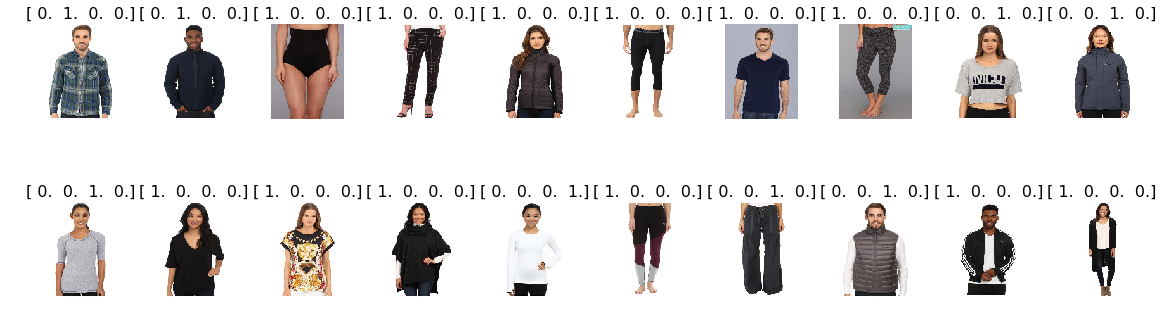

In [81]:
print(train_batches.class_indices)
plots(train_batches[0][0][30:50], titles=train_batches[0][1][30:50])
plt.show()

In [82]:
%%time
m  = models.Sequential()
m.add(layers.Convolution2D(32, (3,3), activation="relu", input_shape=(150,150,3)))
m.add(layers.MaxPooling2D((2,2)))
m.add(layers.Convolution2D(64, (3,3), activation="relu"))
m.add(layers.MaxPooling2D((2,2)))
m.add(layers.Convolution2D(128, (3,3), activation="relu"))
m.add(layers.MaxPooling2D((2,2)))
m.add(layers.Flatten())
m.add(layers.Dense(128, activation="relu"))
m.add(layers.Dense(64, activation="relu"))
m.add(layers.Dense(4, activation="softmax")) #softmax returns a (4,1) vector of probabilities where they all add up to 1

m.compile(
    optimizer=optimizers.rmsprop(),
    loss=losses.categorical_crossentropy,
    metrics=[metrics.categorical_accuracy]
)

h = m.fit_generator(train_batches, epochs=8, steps_per_epoch=20, 
                    validation_data=valid_batches, validation_steps=20)

Epoch 1/8
20/20 [==============================] - 29s 1s/step - loss: 1.7908 - categorical_accuracy: 0.4787 - val_loss: 0.9954 - val_categorical_accuracy: 0.5255
Epoch 2/8
20/20 [==============================] - 22s 1s/step - loss: 1.0323 - categorical_accuracy: 0.5512 - val_loss: 0.9083 - val_categorical_accuracy: 0.5750
Epoch 3/8
20/20 [==============================] - 21s 1s/step - loss: 0.8776 - categorical_accuracy: 0.6190 - val_loss: 0.7991 - val_categorical_accuracy: 0.6690
Epoch 4/8
20/20 [==============================] - 21s 1s/step - loss: 0.8692 - categorical_accuracy: 0.6732 - val_loss: 0.8566 - val_categorical_accuracy: 0.6365
Epoch 5/8
20/20 [==============================] - 21s 1s/step - loss: 0.7224 - categorical_accuracy: 0.7225 - val_loss: 0.7038 - val_categorical_accuracy: 0.7550
Epoch 6/8
20/20 [==============================] - 21s 1s/step - loss: 0.6768 - categorical_accuracy: 0.7365 - val_loss: 0.5913 - val_categorical_accuracy: 0.7890
Epoch 7/8
20/20 [=====

In [83]:
loss, acc = m.evaluate_generator(test_batches)
print(loss, acc)
print((1-acc)*test_batches.samples, "images misclassified")

0.777522695065 0.728500004113
542.999991775 images misclassified


In [73]:
def wrongly_classified(model, stop=None):
    predictions_test = model.predict_generator(test_batches).round(2)
    test_preds = predictions_test.round()
    
    n_batches = len(test_batches) #flattening batches labels into single array
    test_labels = test_batches[0][1]
    for n in range(int(n_batches)):
        if n == 0:
            continue
        test_labels = np.concatenate((test_labels, test_batches[n][1]))
    # https://github.com/keras-team/keras/blob/c2e36f369b411ad1d0a40ac096fe35f73b9dffd3/keras/metrics.py
    # print("categorical_accuracy: ", np.mean(np.equal(np.argmax(test_labels, axis=-1), np.argmax(test_preds, axis=-1))))
    if (test_batches.num_classes == 2):
        test_preds = test_preds.reshape(1,-1)[0]
        wrong_preds = test_preds != test_labels
        print(wrong_preds.sum(), "images misclassified") #needs to reconcile with the number of wrong predictions

    else:
        wrong_preds = np.array([n.argmax() != m.argmax() for n,m in zip(test_labels, test_preds)])
        print(wrong_preds.sum(), "images misclassified") #needs to reconcile with the number of wrong predictions

    for n, index in enumerate(np.where(wrong_preds)[0]):
        if (stop!=None) and (stop == n):
            break
        print(test_batches.class_indices)
        print("{}. Prediction: {}, Label: {}".format(n+1, predictions_test[index], test_labels[index]))
        
        index_photo = index % test_batches.batch_size
        batch_index_photo = int(np.ceil((index+1)/test_batches.batch_size))-1
        plt.imshow(test_batches[batch_index_photo][0][index_photo])
        plt.axis('Off')
        plt.show()

642 images misclassified
{'black': 0, 'blue': 1, 'gray': 2, 'white': 3}
1. Prediction: [ 0.1         0.88999999  0.01        0.        ], Label: [ 1.  0.  0.  0.]


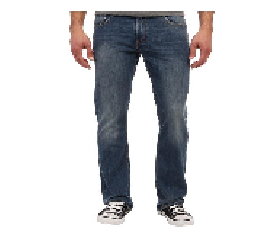

{'black': 0, 'blue': 1, 'gray': 2, 'white': 3}
2. Prediction: [ 0.23999999  0.54000002  0.15000001  0.07      ], Label: [ 1.  0.  0.  0.]


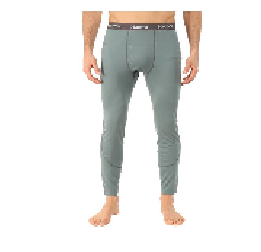

{'black': 0, 'blue': 1, 'gray': 2, 'white': 3}
3. Prediction: [ 0.20999999  0.75999999  0.03        0.        ], Label: [ 1.  0.  0.  0.]


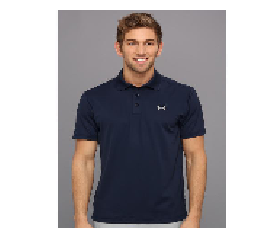

{'black': 0, 'blue': 1, 'gray': 2, 'white': 3}
4. Prediction: [ 0.02        0.98000002  0.          0.        ], Label: [ 1.  0.  0.  0.]


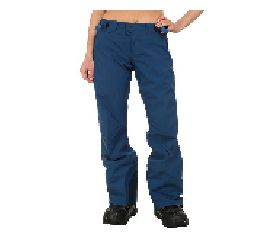

{'black': 0, 'blue': 1, 'gray': 2, 'white': 3}
5. Prediction: [ 0.27000001  0.52999997  0.19        0.01      ], Label: [ 1.  0.  0.  0.]


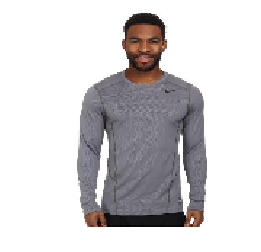

{'black': 0, 'blue': 1, 'gray': 2, 'white': 3}
6. Prediction: [ 0.13        0.86000001  0.01        0.        ], Label: [ 1.  0.  0.  0.]


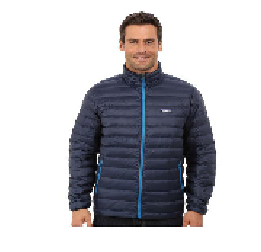

{'black': 0, 'blue': 1, 'gray': 2, 'white': 3}
7. Prediction: [ 0.14        0.82999998  0.01        0.01      ], Label: [ 1.  0.  0.  0.]


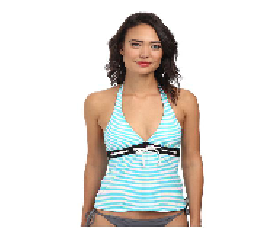

{'black': 0, 'blue': 1, 'gray': 2, 'white': 3}
8. Prediction: [ 0.23        0.75999999  0.02        0.        ], Label: [ 1.  0.  0.  0.]


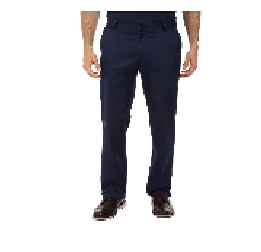

{'black': 0, 'blue': 1, 'gray': 2, 'white': 3}
9. Prediction: [ 0.02        0.98000002  0.          0.        ], Label: [ 1.  0.  0.  0.]


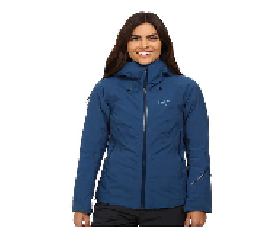

{'black': 0, 'blue': 1, 'gray': 2, 'white': 3}
10. Prediction: [ 0.14        0.86000001  0.          0.        ], Label: [ 1.  0.  0.  0.]


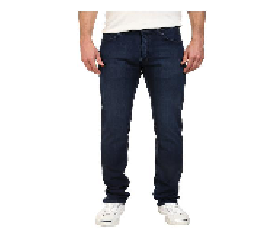

In [114]:
wrongly_classified(m, stop=10)

### Some images have been incorrectly labeled in the original dataframe

To fix them we will do the folling:
1. Extract images by color - *extract_colors* -function
2. Explore the images pick up de incorrect ones
3. Run the model a few times to get more incorrect images - *wrongly_labeled * -function

In [16]:
def extract_colors(df, classes, n_images, images_path):
    """
    - classes need to match the category labels
    - images_path is the absolute path to the img folder
    """
                   
    assert (type(classes) == list)&(type(n_images) == list), "needs to be in list format"
    
    path_cwd = os.getcwd() #using output path by default

    for n, each_class in enumerate(classes):
        clothes_class = df[df["Color"].str.contains(each_class)]["filename"].tolist()
        #make folders and subfolders
        os.makedirs("./images/colors/" + each_class.lower(), exist_ok=True)

        for img_name in clothes_class: #iterate over each filename
            origin_path = os.path.join(images_path, img_name + ".jpg")
            destination_path = os.path.join("./images/colors/", each_class.lower(), img_name + ".jpg")
            copy2(origin_path, destination_path) #will copy the images from origin to destination folder

In [18]:
%%time
extract_colors(df_color_labels,
                 ["Pink", "Brown"],
                 [1269,1605],
                 images_path=img_selected
                )

Wall time: 39.9 s


In [25]:
df_color_labels.groupby('Color').count().sort_values(by='filename', ascending=False).reset_index()

,Color,filename
0,Black,10791
1,Blue,5598
2,Gray,3824
3,White,2861
4,Red,1679
5,Brown,1605
6,Pink,1269
7,Green,1138
8,Beige,1099
9,Purple,854
